In [1]:
%run word_generator

[nltk_data] Downloading package punkt to /Users/sarah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv("reviews.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.shape

(50000, 2)

In [4]:
new_data = modify_data(data, "review", div = 50, min_words = 20, min_sent = 2)
new_data[:10]

,review,sentiment,new_data
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. The filming t...,positive,A wonderful little production. The filming ...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
5,"Probably my all-time favorite movie, a story o...",positive,"Probably my all-time favorite movie, a story o..."
6,I sure would like to see a resurrection of a u...,positive,I sure would like to see a resurrection of a u...
7,"This show was an amazing, fresh & innovative i...",negative,"This show was an amazing, fresh & innovative i..."
8,Encouraged by the positive comments about this...,negative,Encouraged by the positive comments about this...
9,If you like original gut wrenching laughter yo...,positive,If you like original gut wrenching laughter yo...


In [5]:
new_data.shape

(1000, 3)

In [6]:
text = clean(new_data, 'new_data')
print(text)

0      one of the other reviewers has mentioned that ...
1      a wonderful little production the filming tech...
2      i thought this was a wonderful way to spend ti...
3      basically theres a family where a little boy j...
4      petter matteis love in the time of money is a ...
                             ...                        
995    nothing is sacred just ask ernie fosselius fil...
996    i hated it i hate selfaware pretentious inanit...
997    i usually try to be professional and construct...
998    if you like me is going to see this in a film ...
999    this is like a zoology textbook given that its...
Name: new_data, Length: 1000, dtype: object


In [7]:
len(text), type(text)

(1000, pandas.core.series.Series)

In [8]:
def split_data(data):
    """
    The function splits the data into training, validation, and testing sets. The training data is 80% of the data, while the 
    validation and testing sets equally make up the other 20% of the data (they are both 10% of data).
    @param data: a dataset
    @rvalue train_data: 80% of original data
    @rvalue val_data: 10% of original data
    @rvalue test_data: 10% of original data
    """
    # training data is 80% of data
    train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42) 
    # validation data and testing data are both 10% of data
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42) 
    return train_data, val_data, test_data

In [9]:
train_data, val_data, test_data = split_data(text)
len(train_data), len(val_data), len(test_data)

(800, 100, 100)

In [10]:
def tokenize(train_data):
    """
    This function tokenizes the training text data and then returns the train_data, total_words, and tokenizer.
    @param text: string object
    @rvalue text: string object tokenized
    @rvalue total_words: length of word index + 1
    @rvalue tokenizer: tokenizer from tensorflow package
    """
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(train_data) # fit on series of text
    total_words = len(tokenizer.word_index) + 1 # length of word index
    return train_data, tokenizer

In [11]:
train_data, tokenizer = tokenize(train_data)

In [12]:
def input_seq(train, val, test, tokenizer):
    """
    This function creates input sequences for the Sequential model. The input sequences are created by using n grams of 
    each tokenized review. Each n gram in the sequence is then padded with zeros to the length of the largest n gram sequence
    in the training data.The x variable represents the predictor data, meaning it is all the data in the input sequence, minus the last token. The 
    y variable is the target and what the model aims to predict. Therefor the y variable is the last token "word" in the input
    sequences.
    @param train, val, test: text objects with training, validation, and testing data
    @param tokenizer: tokenizer object from tensorflow
    @rvalue train_x, val_x, test_x: numpy arrays of integers (represents predictor data)
    @rvalue train_y, val_y, test_y: numpy arrays of integers (represents target data)
    @rvalue total_words: int, length of word index
    """
    # create n gram sequences
    def create_sequences(text):
        """
        This function creates n gram sequences for the text.
        @param text: string object
        """
        input_sequences = []
        for line in text: # for each review
            token_list = tokenizer.texts_to_sequences([line])[0] # map each unique word to an integer with tokenizer
            # Creating n gram for each review
            for i in range(1, len(token_list)): 
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence) # input_sequences is a list of sequences from tokenized reviews
        return input_sequences
    
    # total words
    total_words = len(tokenizer.word_index) + 1
    
    # create n gram sequences for training, validation, and testing data
    train_seq = create_sequences(train)
    val_seq = create_sequences(val)
    test_seq = create_sequences(test)
    
    # padding sequences so each sequence in input_sequences has the same length
    max_sequence_len = max(max([len(x) for x in train_seq]),
                           max([len(x) for x in val_seq]),
                           max([len(x) for x in test_seq])) # identify length of largest sequence
    
    # pre pad sequences with zeros if length of max_sequence_len is not met
    train_seq = pad_sequences(train_seq, maxlen=max_sequence_len, padding='pre')
    val_seq = pad_sequences(val_seq, maxlen=max_sequence_len, padding='pre')
    test_seq = pad_sequences(test_seq, maxlen=max_sequence_len, padding='pre')

    # create predictor and target data 
    def split_sequences(sequences):
        """
        @param sequences:
        @rvalue x: numpy array of integers (represents predictor data)
        @rvalue y: numpy array of integers (represents target data)
        """
        x = sequences[:, :-1] # the tokenized sequences minus the last token
        y = sequences[:, -1] # the last token for each tokenized sequence
        return x, y
    
    # generate predictor and target data for training, validation, and testing data
    train_x, train_y = split_sequences(train_seq)
    val_x, val_y = split_sequences(val_seq)
    test_x, test_y = split_sequences(test_seq)
    
    return train_x, train_y, val_x, val_y, test_x, test_y, total_words, max_sequence_len

In [13]:
train_x, train_y, val_x, val_y, test_x, test_y, total_words, max_seq_len = input_seq(train_data, val_data, test_data, tokenizer)

In [14]:
def prepare_for_model(train_x, train_y, val_x, val_y, test_x, test_y, total_words):
    """
    This function applies the one-hot encoding to the predictor data and then converts all the data into numpy arrays.
    @param train_x, val_x, test_x: numpy arrays of integers (represents predictor data)
    @param train_y, val_y, test_y: numpy arrays of integers (represents target data)
    @rvalue train_x, val_x, test_x: numpy arrays of integers (represents predictor data)
    @rvalue train_y, val_y, test_y: numpy arrays of one-hot encoded data (represents target data)
    """
    # convert target data to binary class matrices
    train_y = np.array(tf.keras.utils.to_categorical(train_y, num_classes=total_words))
    val_y = np.array(tf.keras.utils.to_categorical(val_y, num_classes=total_words))
    test_y = np.array(tf.keras.utils.to_categorical(test_y, num_classes=total_words))
    
    # convert data to numpy arrays to ensure model compatability
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    val_x = np.array(val_x)
    val_y = np.array(val_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [15]:
train_x, train_y, val_x, val_y, test_x, test_y = prepare_for_model(train_x, train_y, val_x, val_y, test_x, test_y, total_words)

In [16]:
# shape of predictor data should be (number of sequences, max sequence length - 1)
# shape of target data should be (number of sequences, total_words)
print("max_sequence_len:", max_seq_len) 
print("Total words:", total_words)
print("Shape of train_x: ", train_x.shape, " Type of train_x: ", type(train_x))
print("Shape of train_y: ", train_y.shape, " Type of train_y: ", type(train_y))
print("Shape of val_x: ", val_x.shape, " Type of val_x: ", type(val_x))
print("Shape of val_y: ", val_y.shape, " Type of val_y: ", type(val_y))
print("Shape of test_x: ", test_x.shape, " Type of test_x: ", type(test_x))
print("Shape of test_y: ", test_y.shape, " Type of test_y: ", type(test_y))

max_sequence_len: 166
Total words: 6262
Shape of train_x:  (30687, 165)  Type of train_x:  <class 'numpy.ndarray'>
Shape of train_y:  (30687, 6262)  Type of train_y:  <class 'numpy.ndarray'>
Shape of val_x:  (3250, 165)  Type of val_x:  <class 'numpy.ndarray'>
Shape of val_y:  (3250, 6262)  Type of val_y:  <class 'numpy.ndarray'>
Shape of test_x:  (3414, 165)  Type of test_x:  <class 'numpy.ndarray'>
Shape of test_y:  (3414, 6262)  Type of test_y:  <class 'numpy.ndarray'>


In [17]:
# Model 1
model = tf.keras.models.Sequential([
        layers.Embedding(input_dim = total_words, output_dim = 100, input_length = max_seq_len-1),
        layers.LSTM(100),
        layers.Dense(total_words, activation='softmax'),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 165, 100)          626200    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6262)              632462    
                                                                 
Total params: 1339062 (5.11 MB)
Trainable params: 1339062 (5.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
callback = EarlyStopping(patience=5, monitor='val_loss') # stop training when validation accuracy doesn't improve
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_x, train_y,
                    epochs=20,
                    validation_data=(val_x, val_y),
                    verbose=1, callbacks=[callback])

Epoch 1/20
959/959 [==============================] - 84s 87ms/step - loss: 2.0295 - accuracy: 0.5797 - val_loss: 7.5604 - val_accuracy: 0.0942
Epoch 2/20
959/959 [==============================] - 83s 87ms/step - loss: 1.7513 - accuracy: 0.6508 - val_loss: 7.7078 - val_accuracy: 0.0892
Epoch 3/20
959/959 [==============================] - 84s 87ms/step - loss: 1.5953 - accuracy: 0.6793 - val_loss: 7.8684 - val_accuracy: 0.0877
Epoch 4/20
959/959 [==============================] - 84s 88ms/step - loss: 1.4657 - accuracy: 0.7067 - val_loss: 8.0580 - val_accuracy: 0.0905
Epoch 5/20
959/959 [==============================] - 84s 88ms/step - loss: 1.3560 - accuracy: 0.7270 - val_loss: 8.1791 - val_accuracy: 0.0920
Epoch 6/20
959/959 [==============================] - 88s 91ms/step - loss: 1.2572 - accuracy: 0.7446 - val_loss: 8.3514 - val_accuracy: 0.0865


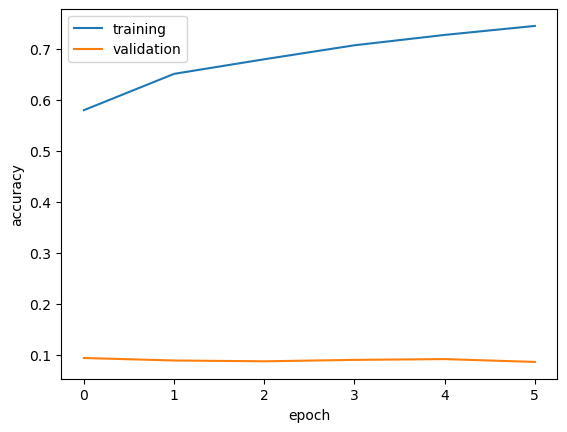

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

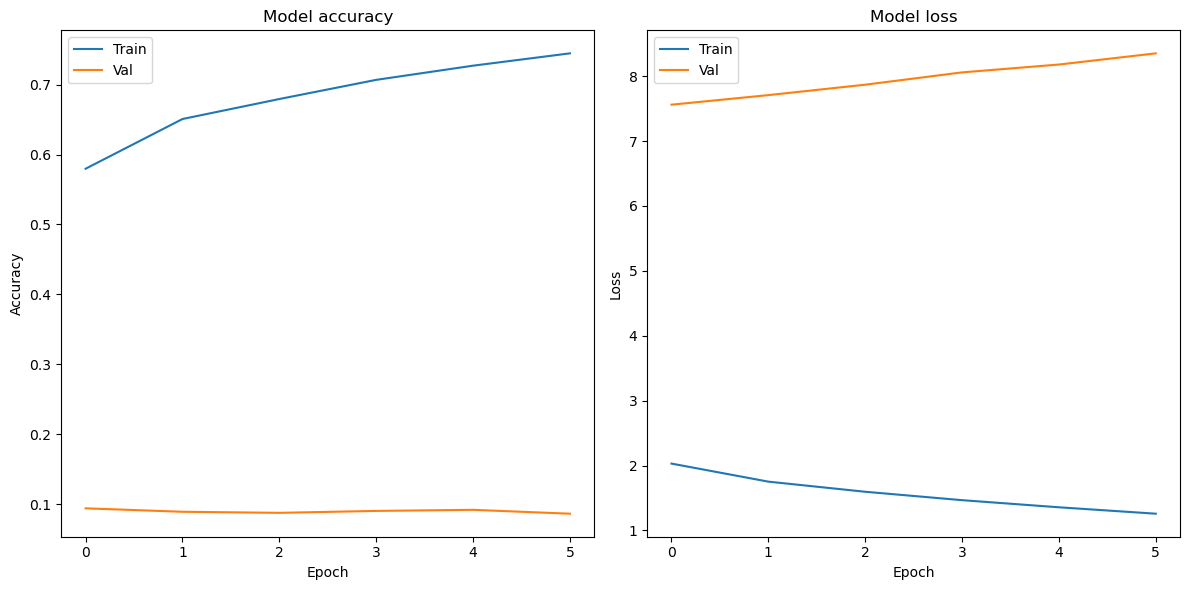

In [27]:
def evaluate_model(model, history, test_x, test_y):
    """
    This function creates plots using matplotlib to plot the model accuracy and loss across epochs for the training and 
    validation datasets. This function then prints out the loss and accuracy percent when the model is evaluated on the 
    testing datasets.
    @param model: a tensorflow Sequential model
    @param history: History callback object that keeps track of metrics for model
    @param test_x: numpy array, representing predictor testing set
    @param test_y: numpy array, representing target testing set
    """
    
    plt.figure(figsize=(12, 6))

    # plot training & validation model accuracy across epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    # plot training & validation model loss values across epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
    
    loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
    print(f'Test accuracy: {accuracy*100:.2f}%, Test loss: {loss}')

In [29]:
def generate_review(model, tokenizer, seed_text, max_sequence_len, review_length):
    """
    Generate a review from a seed text.

    Parameters:
    - model: Trained Keras model for text generation.
    - tokenizer: Tokenizer used for training the model.
    - seed_text: Initial text to start the review generation.
    - max_sequence_len: Maximum length of sequences used during training.
    - review_length: Desired length of the generated review.

    Returns:
    - A string containing the generated review.
    """
    for _ in range(review_length):
        # tokenize current text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # pad sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # predict next word (probability distribution over vocab)
        predicted = model.predict(token_list, verbose=0)
        # convert to single word index
        predicted_index = np.argmax(predicted, axis=-1)[0]
        # convert word index back to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        # append predicted word to text
        seed_text += " " + output_word
        # consider putting stopping criterion?
        # EX:  if output_word == 'endToken': break
    return seed_text

# Example usage
# Assuming you have a 'tokenizer' that was used during model training
seed_text = "The movie was"
review_length = 50  # Generate a review of approximately 50 words
generated_review = generate_review(model, tokenizer, seed_text, max_seq_len, review_length)
print(generated_review)

The movie was about a psychic woman tory who returns to her hometown and begins reliving her traumatic childhood past the death of her childhood friend and abusive father tory discovers that her friend was the first installment of their flight by a forgotten desert one lone survivor attempting to rekindle his sanity
